In [39]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression

In [40]:
# Load data
data = loadmat('./ex5data1.mat')
X = data['X']
y = data['y']
Xtest = data['Xtest']
ytest = data['ytest']
Xval = data['Xval']
yval = data['yval']
print(X.shape)
print(y.shape)

(12, 1)
(12, 1)


### 1.1 Visualizing the dataset

In [41]:
def plot_data(X, y, label_x, label_y, axes=None):
    if not axes:
        axes = plt.gca()
    axes.scatter(X,y, label='Training data', marker='x')
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend()

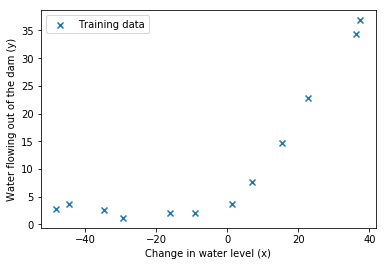

In [42]:
plot_data(X, y, 'Change in water level (x)', 'Water flowing out of the dam (y)')

### 1.2 Regularized linear regression cost function

In [43]:
def linear_reg_cost_function(theta, X, y, lamb=1):
    m = len(y)
    hx = X.dot(theta.reshape(-1,1))
    J = (1/(2*m))*(np.sum(np.square(hx-y))) + (lamb/(2*m))*(np.sum(np.square(theta[1:])))
    
    return J

In [44]:
def linear_reg_gradient(theta, X, y, lamb=1):
    m = len(y)
    hx = X.dot(theta.reshape(-1,1))
    grad = (1/m)*((hx-y).T.dot(X)) + (lamb/m)*(np.c_[[0],[theta[1:]]])
    
    return grad.flatten()

In [45]:
X_in = np.c_[np.ones((X.shape[0],1)), X]
theta_init = np.ones((X_in.shape[1]))

In [46]:
cost = linear_reg_cost_function(theta_init, X_in, y, 1)
grad = linear_reg_gradient(theta_init, X_in, y, 1)
print(cost)
print(grad)

303.9931922202643
[-15.30301567 598.25074417]


### 1.4 Fitting linear regression

In [47]:
def train_linear_reg(X, y, lamb):
    theta = np.ones((X.shape[1]))
    res = minimize(linear_reg_cost_function, theta, method='CG', args=(X,y,lamb), \
                   jac=linear_reg_gradient, options={'disp': False})
    
    return res.x

In [48]:
theta = train_linear_reg(X_in, y, 0)

In [49]:
def predict(theta, X):
#     X_2d = X.reshape(-1,1)
#     X_in = np.c_[np.ones((X_2d.shape[0],1)), X_2d]
    return X.dot(theta.reshape(-1,1)).flatten()

In [50]:
def plot_fit(theta, X, y, axes=None):
    X_min, X_max = np.min(X), np.max(X)
    plot_X = np.linspace(X_min, X_max).reshape(-1,1)
    X_in = np.c_[np.ones((plot_X.shape[0],1)), plot_X]
    plot_y = predict(theta, X_in)
    if axes == None:
        axes = plt.gca()
    axes.plot(plot_X.flatten(), plot_y,label='Linear fit', color='r')
    plot_data(X, y, 'Change in water level (x)', 'Water flowing out of the dam (y)', axes)

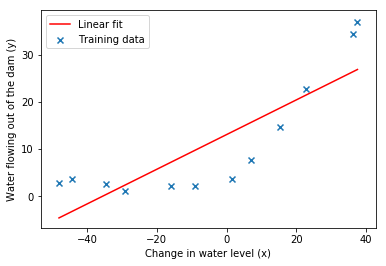

In [51]:
plot_fit(theta, X, y)

### 2.1 Learning curves

In [52]:
def evaluate(ground_truth, prediction):
    return np.mean(np.square(ground_truth.ravel() - prediction.ravel()))/2

In [53]:
def learning_curve(X, y, Xval, yval, lamb):
    m = len(y)
    error_train = []
    error_val = []
    for i in range(1, m):
        X_in = np.c_[np.ones((i, 1)), X[:i]]
        y_in = y[:i]
        theta = train_linear_reg(X_in, y_in, lamb)
        
        Xval_in = np.c_[np.ones((Xval.shape[0],1)), Xval]
        
        pred_train = predict(theta, X_in)
        pred_val = predict(theta, Xval_in)

        error_train.append(evaluate(y_in, pred_train))
        error_val.append(evaluate(yval, pred_val))
        
    return error_train, error_val

In [54]:
error_train, error_val = learning_curve(X, y, Xval, yval, 1)

In [55]:
def plot_learning_curve(error_train, error_val, axes=None):
    if axes == None:
        axes = plt.gca()
        
    axes.plot(np.linspace(1, len(error_train), len(error_train)), error_train, label='Train')
    axes.plot(np.linspace(1, len(error_val), len(error_val)), error_val, label='Cross Validation')
    axes.set_xlabel('Number of training examples')
    axes.set_ylabel('Error')
    axes.legend()

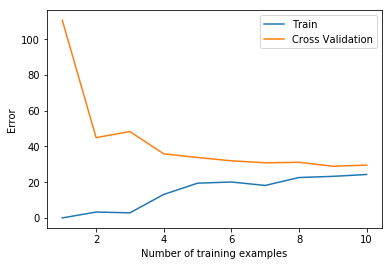

In [56]:
plot_learning_curve(error_train[1:], error_val[1:])

### 3 Polynomial regression

In [57]:
def poly_features(X, p):
    X_poly = np.array(X)
    for i in range(2, p+1):
        X_poly = np.c_[X_poly, np.power(X, i)]
    return X_poly

In [58]:
def feature_normalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X , axis=0)
    X_norm = (X - mu)/sigma
    
    return X_norm, mu, sigma

In [59]:
def feature_normalize_with_params(X, mu, sigma):
    return (X - mu)/sigma

In [60]:
p = 8
X_poly, mu, sigma = feature_normalize(poly_features(X, p))
X_poly = np.c_[np.ones((X_poly.shape[0],1)), X_poly]

X_poly_test = feature_normalize_with_params(poly_features(Xtest, p), mu, sigma)
X_poly_test = np.c_[np.ones((X_poly_test.shape[0],1)), X_poly_test]

X_poly_val = feature_normalize_with_params(poly_features(Xval, p), mu, sigma)
X_poly_val = np.c_[np.ones((X_poly_val.shape[0],1)), X_poly_val]

### 3.1 Learning Polynomial Regression

In [61]:
theta_poly = train_linear_reg(X_poly, y, 0)

In [62]:
reg = LinearRegression().fit(X_poly, y)

In [63]:
def plot_fit(min_x, max_x, p, theta=None, r=None, axes=None):
    x = np.linspace(min_x-15, max_x+10).reshape(-1,1)
    X_poly = feature_normalize_with_params(poly_features(x, p), mu, sigma)
    X_poly = np.c_[np.ones((X_poly.shape[0],1)), X_poly]
    pred = X_poly.dot(theta) if not r else r.predict(X_poly)
    if axes == None:
        axes = plt.gca()
    axes.plot(x, pred, label='Poly fit, p = 8', color='r')
    plot_data(X, y, 'Change in water level (x)', 'Water flowing out of the dam (y)', axes)

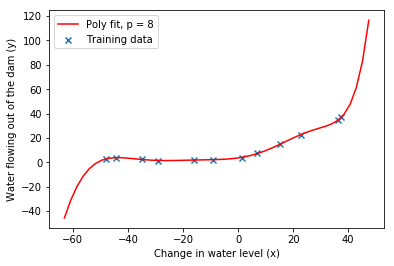

In [64]:
plot_fit(np.min(X), np.max(X), p, theta=theta_poly)

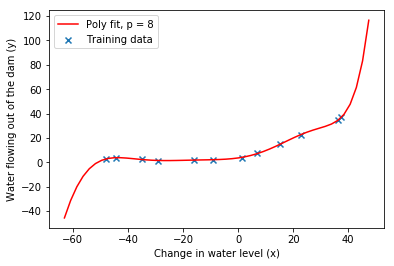

In [65]:
plot_fit(np.min(X), np.max(X), p, r=reg)

In [66]:
error_train_poly, error_val_poly = learning_curve(X_poly, y, X_poly_val, yval, 0)

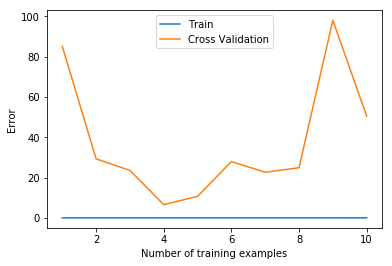

In [67]:
plot_learning_curve(error_train_poly[1:], error_val_poly[1:])

### 3.2 Adjusting the regularization parameter

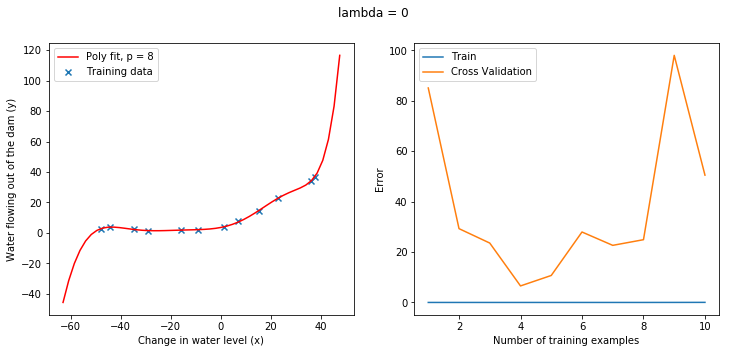

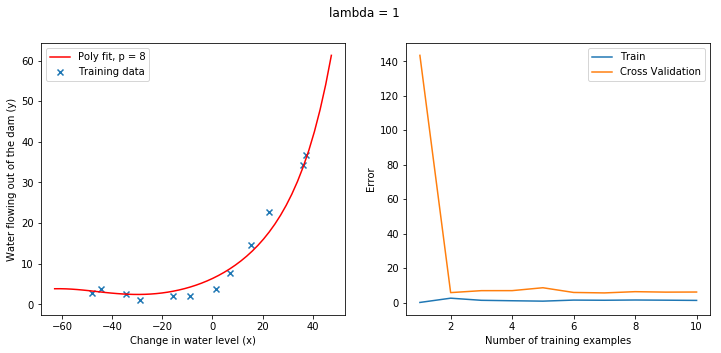

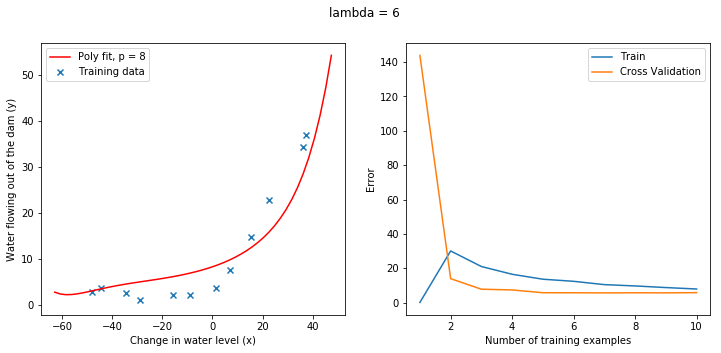

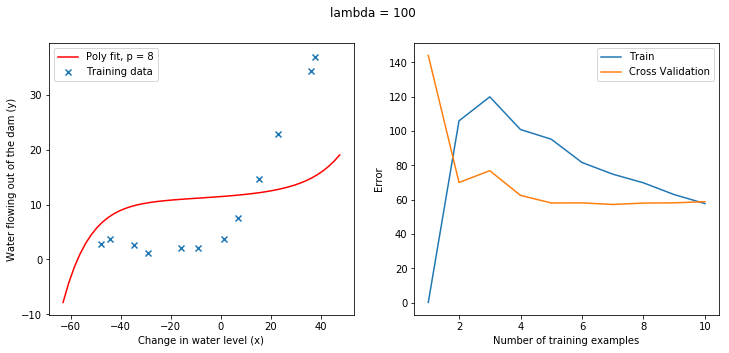

In [74]:
lambs = [0,1,6,100]
for i in range(len(lambs)):
    lamb = lambs[i]
    theta_poly = train_linear_reg(X_poly, y, lamb)
    error_train_poly, error_val_poly = learning_curve(X_poly, y, X_poly_val, yval, lamb)
    
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    fig.suptitle('lambda = {}'.format(lamb))
    plot_fit(np.min(X), np.max(X), p, theta=theta_poly, axes=ax[0])
    plot_learning_curve(error_train_poly[1:], error_val_poly[1:], axes=ax[1])

### 3.3 Selecting lambda using a cross validation set

In [69]:
def validation_curve(X, y, Xval, yval):
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    error_train = []
    error_val = []
    for i in range(len(lambda_vec)):
        lamb = lambda_vec[i]
        X_in = np.c_[np.ones((X.shape[0],1)), X]
        Xval_in = np.c_[np.ones((Xval.shape[0],1)), Xval]
        
        theta = train_linear_reg(X_in, y, lamb)
        
        pred_train = predict(theta, X_in)
        pred_val = predict(theta, Xval_in)
        error_train.append(evaluate(y, pred_train))
        error_val.append(evaluate(yval, pred_val))
        
    return lambda_vec, error_train, error_val

In [72]:
def plot_validation_curve(error_train, error_val, axes=None):
    if axes == None:
        axes = plt.gca()
    axes.plot(error_train, label='Train')
    axes.plot(error_val, label='Cross Validation')
    axes.set_xlabel('lambda')
    axes.set_ylabel('Error')
    axes.legend()

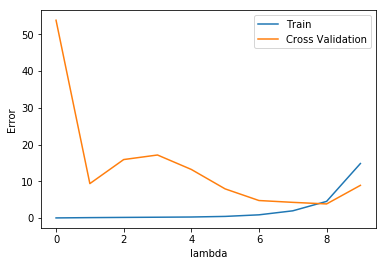

In [73]:
lambda_vec, error_train, error_val = validation_curve(X_poly, y, X_poly_val, yval)
plot_validation_curve(error_train, error_val)